## Topics of hateful articles

Basado fuertemente en [esta notebook](https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/Evaluate%20Topic%20Models.ipynb)

En esta notebook veremos los tópicos de los artículos que generan cierto odio

In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import json
from mongoengine import connect
from hatespeech_models import Tweet, Article

with open("../data/coronavirus-argentina-v2.json") as f:
    all_articles = json.load(f)

In [3]:
articles = [art for art in all_articles if len(art["comments"]) >= 20]

print(len(articles))


6519


In [4]:
sum(len(art["comments"]) for art in articles)

658976

In [5]:
from tqdm.auto import tqdm

for article in tqdm(articles):
    hateful_comments = [c for c in article["comments"] if c["hateful_value"] > 0.5]
    
    article["num_hateful_comments"] = len(hateful_comments)
    article["avg_hateful_comments"] = len(hateful_comments) / len(article["comments"])
    article["avg_hate_value"] = sum(c["hateful_value"] for c in article["comments"]) / len(article["comments"])


<AxesSubplot:>

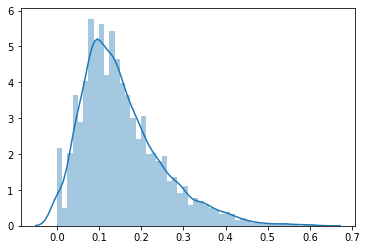

In [6]:
import seaborn as sns


sns.distplot([[art["avg_hateful_comments"] for art in articles]])

In [7]:
hateful_articles = [art for art in articles if art["avg_hateful_comments"] > 0.13]
len(hateful_articles)

3399

In [8]:
from contextualized_topic_models.models.ctm import CTM
from contextualized_topic_models.utils.data_preparation import TextHandler
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_file
from contextualized_topic_models.datasets.dataset import CTMDataset


In [9]:
import torch

torch.cuda.device_count()

2

In [10]:
import spacy
from tqdm.auto import tqdm
import scipy

nlp = spacy.load("es", disable=["parser", "ner"])

class MyTextHandler:

    def __init__(self):
        self.vocab_dict = {}
        self.vocab = []
        self.index_dd = None
        self.idx2token = None
        self.bow = None

    def prepare(self, articles):
        indptr = [0]
        indices = []
        data = []
        vocabulary = {}

        for art in tqdm(articles):
            for term in nlp(art["body"]):
                token = term.string
                index = vocabulary.setdefault(token, len(vocabulary))
                indices.append(index)
                data.append(1)
            indptr.append(len(indices))

        self.vocab_dict = vocabulary
        self.vocab = list(vocabulary.keys())
        self.idx2token = {v: k for (k, v) in self.vocab_dict.items()}
        self.bow = scipy.sparse.csr_matrix((data, indices, indptr), dtype=int)

In [11]:
handler = MyTextHandler()
handler.prepare(hateful_articles) # create vocabulary and training data


In [12]:
bert_embeddings_from_file??

Signature: bert_embeddings_from_file(text_file, sbert_model_to_load)
Docstring: <no docstring>
Source:   
def bert_embeddings_from_file(text_file, sbert_model_to_load):
    model = SentenceTransformer(sbert_model_to_load)

    with open(text_file, encoding="latin") as filino:
        train_text = list(map(lambda x: x, filino.readlines()))

    return np.array(model.encode(train_text))
File:      ~/.local/share/virtualenvs/hatespeech-labelling-i4Bxdr6F/lib/python3.6/site-packages/contextualized_topic_models/utils/data_preparation.py
Type:      function


In [13]:
from sentence_transformers import SentenceTransformer

transformer_name = "distiluse-base-multilingual-cased"

sentence_encoder = SentenceTransformer(transformer_name)


In [14]:
import numpy as np

encoded_articles = sentence_encoder.encode([art["body"] for art in hateful_articles])

In [15]:
encoded_articles.shape

(3399, 512)

In [16]:
# generate BERT data
training_bert = encoded_articles

training_dataset = CTMDataset(handler.bow, training_bert, handler.idx2token)

ctm = CTM(input_size=len(handler.vocab), bert_input_size=512, inference_type="contextual", n_components=50)

ctm.fit(training_dataset) # run the mode

Settings: 
               N Components: 50
               Topic Prior Mean: 0.0
               Topic Prior Variance: 0.98
               Model Type: prodLDA
               Hidden Sizes: (100, 100)
               Activation: softplus
               Dropout: 0.2
               Learn Priors: True
               Learning Rate: 0.002
               Momentum: 0.99
               Reduce On Plateau: False
               Save Dir: None
Epoch: [1/100]	Samples: [3399/339900]	Train Loss: 8863.844497002796	Time: 0:00:04.051863
Epoch: [2/100]	Samples: [6798/339900]	Train Loss: 8666.710147975507	Time: 0:00:04.148314
Epoch: [3/100]	Samples: [10197/339900]	Train Loss: 8607.427566012062	Time: 0:00:04.142061
Epoch: [4/100]	Samples: [13596/339900]	Train Loss: 8600.862231998382	Time: 0:00:04.036963
Epoch: [5/100]	Samples: [16995/339900]	Train Loss: 8579.821578957046	Time: 0:00:04.064613
Epoch: [6/100]	Samples: [20394/339900]	Train Loss: 8563.089520814945	Time: 0:00:04.147856
Epoch: [7/100]	Samples: [23793/

In [22]:

for i, topic in enumerate(ctm.get_topic_lists(k=30)):
    print(f"Tópico {i}: \n {' - '.join(topic)}\n\n")

Tópico 0: 
 es  - se  - que  - los  - .  - no  - hay  - el  - en  - más  - un  - una  - tiene  - está  - si  - lo  - va  - puede  - para  - o  - la  - muy  - pero  - gente  - pandemia  - son  - ¿ - casos  - salud  - a 


Tópico 1: 
 presos  - prisión  - detenidos  - riesgo  - cárcel  - penal  - grupo  - detenido  - Unidad  - fuentes  - años  - Covid-19 - arresto  - dentro  - Servicio  - ordenó  - Melchor  - delitos  - fueron  - D’Elía  - Penitenciario  - Los  - condenado  - Hong - Jae  - Jaime  - Nara - problemas  - /  - domiciliaria 


Tópico 2: 
 ,  - de  - y  - la  - en  - a  - el  - los  - por  - las  - .  - 

 - una  - con  - se  - que  - del  - . - su  - un  - “ - al  - ” - sus  - para  - no  - :  - El  - La  - es 


Tópico 3: 
 virus  - Estados  - China  - ha  - han  - Unidos  - mundo  - coronavirus  - pandemia  - Unidos - podría  - según  - China - virus - COVID-19 - sido  - nuevo  - mundo - vacuna  - datos  - estudio  - países  - Universidad  - OMS - principal  - acuerdo  - gr

In [7]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
" - ".join(stop_words)

'de - la - que - el - en - y - a - los - del - se - las - por - un - para - con - no - una - su - al - lo - como - más - pero - sus - le - ya - o - este - sí - porque - esta - entre - cuando - muy - sin - sobre - también - me - hasta - hay - donde - quien - desde - todo - nos - durante - todos - uno - les - ni - contra - otros - ese - eso - ante - ellos - e - esto - mí - antes - algunos - qué - unos - yo - otro - otras - otra - él - tanto - esa - estos - mucho - quienes - nada - muchos - cual - poco - ella - estar - estas - algunas - algo - nosotros - mi - mis - tú - te - ti - tu - tus - ellas - nosotras - vosostros - vosostras - os - mío - mía - míos - mías - tuyo - tuya - tuyos - tuyas - suyo - suya - suyos - suyas - nuestro - nuestra - nuestros - nuestras - vuestro - vuestra - vuestros - vuestras - esos - esas - estoy - estás - está - estamos - estáis - están - esté - estés - estemos - estéis - estén - estaré - estarás - estará - estaremos - estaréis - estarán - estaría - estarías -

## Tokenizar

In [8]:
import spacy
from tqdm.auto import tqdm

lemmatized_data = []

for art in tqdm(hateful_articles):
    lemmatized_data.append([t.lemma_.lower() for t in nlp(art["body"])])


In [9]:
import string

def is_punct_or_other(tok):
    return (tok in string.punctuation) or ("\n" in tok) or (len(tok) <= 3 and not tok.isalpha())


def filter_words(text):
    non_stop = [tok.strip() for tok in text if tok not in stop_words]
    non_punct = [tok for tok in non_stop if not is_punct_or_other(tok)]
    return non_punct

filtered_data = []

for text in tqdm(lemmatized_data):
    filtered_data.append(filter_words(text))

Sanity check

In [10]:


filter_words([t.string for t in nlp("Hola , esto. es una prueba e33 ?")])

['Hola', 'es', 'una', 'prueba']

In [11]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(filtered_data)

# Create Corpus
texts = filtered_data

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 2), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 4), (23, 4), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 5), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 4), (47, 1), (48, 12), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 4), (76, 1), (77, 1), (78, 1), (79, 1), (80, 8), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 3), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 3), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1

In [13]:
import gensim
import pickle

num_topics = range(2, 40, 2)
# Build LDA model

try:
    with open("topic_models.pkl", "rb") as f:
        lda_models, coherence_models = pickle.load(f)        
except FileNotFoundError:
    lda_models = {}
    coherence_models = {}

Se me borró el gráfico pero el que mejor daba es 14 

In [ ]:

for num in tqdm(num_topics):
    if num in lda_models:
        continue
    model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num, 
        random_state=100,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True)
    lda_models[num] = model
    coherence_models[num] = gensim.models.CoherenceModel(model, texts=texts, corpus=corpus, dictionary=id2word, coherence='c_v')


Salvamos esto

In [ ]:
import pickle

with open("topic_models.pkl", "wb") as f:
    pickle.dump((lda_models, coherence_models), f)

In [17]:
Y = [k.get_coherence() for k in coherence_models.values()]

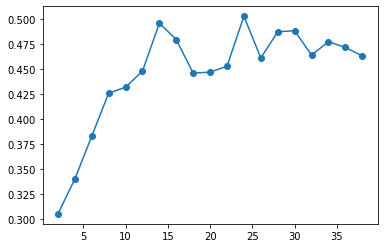

In [18]:
import matplotlib.pyplot as plt


plt.plot([k for k in coherence_models], Y, marker="o")

Agarro 12 que es el más chico donde más o menos deja de crecer

In [39]:
lda_model = lda_models[12]

In [40]:
from pprint import pprint

pprint(lda_model.print_topics())

[(0,
  '0.052*"carne" + 0.039*"consumir" + 0.025*"humano" + 0.024*"cuota" + '
  '0.024*"rata" + 0.022*"agricultura" + 0.019*"humanar" + 0.017*"2021" + '
  '0.016*"anual" + 0.015*"transferencia"'),
 (1,
  '0.075*"ser" + 0.029*"tener" + 0.023*"haber" + 0.020*"parir" + 0.020*"hacer" '
  '+ 0.017*"decir" + 0.016*"poder" + 0.015*"comer" + 0.013*"ir" + 0.010*"si"'),
 (2,
  '0.023*"parir" + 0.017*"país" + 0.015*"ser" + 0.014*"haber" + '
  '0.010*"argentino" + 0.009*"argentina" + 0.007*"comer" + 0.006*"personar" + '
  '0.006*"poder" + 0.006*"entrar"'),
 (3,
  '0.017*"ser" + 0.014*"justicia" + 0.013*"juez" + 0.012*"causar" + '
  '0.009*"parir" + 0.009*"denunciar" + 0.009*"año" + 0.008*"haber" + '
  '0.007*"casar" + 0.007*"judicial"'),
 (4,
  '0.020*"mujer" + 0.017*"hijo" + 0.012*"gustar" + 0.012*"video" + '
  '0.011*"contar" + 0.010*"redar" + 0.010*"casar" + 0.010*"twitter" + '
  '0.009*"compartir" + 0.008*"parejo"'),
 (5,
  '0.022*"productor" + 0.022*"vecino" + 0.021*"santa" + 0.019*"negro" + 

In [41]:
# Print the Keyword in the 10 topics

doc_lda = lda_model[corpus]

In [42]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.319211  0.125054       1        1  35.792715
2     -0.140191  0.013962       2        1  16.015205
9     -0.020188  0.114654       3        1  12.760606
4     -0.245128  0.327355       4        1   7.472177
7      0.060550  0.384617       5        1   6.831059
3     -0.313489 -0.101222       6        1   6.336187
6      0.178949  0.224490       7        1   5.344474
8      0.331042  0.130198       8        1   5.330437
10    -0.146492 -0.309682       9        1   2.505023
5      0.074566 -0.415631      10        1   1.299688
0      0.329840 -0.239699      11        1   0.311306
11     0.209754 -0.254096      12        1   0.001123, topic_info=             Term          Freq         Total Category  logprob  loglift
216           ser  40593.000000  40593.000000  Default  30.0000  30.0000
177         parir  20462.000000  20462.000000  Default  29.0000  29.0000
392    presidente   4196.000000   4196.000000  Default  28.0000  28.0000
1719    fernández   3235.000000   3235.000000  Default  27.0000  27.0000
228         tener  14428.000000  14428.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
13931    grabarse      0.000338      0.984737  Topic12 -10.6389   3.4189
13930     doblaje      0.000338      0.984027  Topic12 -10.6389   3.4197
13929         cid      0.000338      0.989525  Topic12 -10.6389   3.4141
13928      cherri      0.000338      0.984311  Topic12 -10.6389   3.4194
13927     celeste      0.000338      1.004964  Topic12 -10.6389   3.3986

[763 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
5         1  0.003120   2020
5         2  0.132898   2020
5         3  0.194668   2020
5         4  0.386840   2020
5         5  0.102949   2020
...     ...       ...    ...
822       2  0.226118   área
822       3  0.646576   área
822       6  0.046446   área
822       7  0.019556   área
3125      1  0.994868  época

[1483 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 10, 5, 8, 4, 7, 9, 11, 6, 1, 12])

1. Tema "general" (verbos, y otras cosas)
2. Tema "internacional" (China, Trump, avión, extranjero, George Floyd, otros
3. AMBA/CABA: Kicillof, Larreta, Berni: política CABA, AMBA y demás
4. Mujeres y feminismo
5. JxC vs FDT: Macri, Cristina, expropiación, Senado, etc
6. Judiciales/Policiales
7. Conflictos sindicales y económicos: Moyano, pago, grabois, ife, k, camioneros,e tc
8. Notas económicas: dólar, pobreza, silobolsas, default, impuestos, guzmán
9. Salud
10. Conflictos "campo": Vicentín y silobolsas
11. China y su comida?
12. Ruido


In [43]:
temas = [
    "general",
    "internacional",
    "amba/caba",
    "mujeres",
    "cambiemos vs fdt",
    "judiciales y policiales",
    "sindicales",
    "económicas",
    "salud",
    "Campo conflictos",
    "China comida?",
    "Ruido",
]

len(temas)

12

In [44]:
len(corpus), len(hateful_articles)

(3399, 3399)

In [47]:
num = 3

def display_topics(num):
    print(hateful_articles[num]["title"])
    
    topics = lda_model.get_document_topics(corpus[num])
    
    
    print(" + ".join(f"{temas[idx]} * {porc:.2f}" for idx, porc in topics))


for num in range(len(hateful_articles)):
    print("=" * 80 + '\n\n')
    
    display_topics(num)



Los contagios confirmados por dengue superan los 41 mil y 2020 ya tiene el mayor número de casos de la historia
internacional * 0.21 + amba/caba * 0.36 + cambiemos vs fdt * 0.02 + judiciales y policiales * 0.07 + salud * 0.03 + Campo conflictos * 0.11 + China comida? * 0.20


Cambios en el directorio de YPF. Asumieron Héctor Recalde y Celso Jaque
internacional * 0.19 + amba/caba * 0.06 + mujeres * 0.04 + cambiemos vs fdt * 0.02 + sindicales * 0.18 + económicas * 0.34 + salud * 0.07 + Campo conflictos * 0.11


Coronavirus en Argentina: en countries de zona Norte pidieron que jardineros y pileteros trabajaran igual pese a la cuarentena
internacional * 0.16 + amba/caba * 0.17 + mujeres * 0.03 + cambiemos vs fdt * 0.02 + judiciales y policiales * 0.11 + sindicales * 0.15 + Campo conflictos * 0.33 + China comida? * 0.02


Brasil se encamina a la tormenta perfecta: coronavirus, influenza, dengue y sarampión
internacional * 0.26 + amba/caba * 0.30 + económicas * 0.04 + salud * 0.08 + Campo 

In [ ]:
lda_model.get_document_topics()